In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(color_codes=True)
sns.set_context("talk")

df = pd.read_csv('../data/Final_Monster_Data.csv')
df.head()

,Unnamed: 0,size,type,ac,hp,cr,speed,swim,fly,strength,dex,con,intel,wis,cha,legendary,multiattack
0,0,medium,humanoid,12.0,13,0.25,20,0,50,10,14,10,11,12,11,0,0
1,1,medium,humanoid,12.0,84,9.00,30,0,0,9,14,14,18,12,11,0,0
2,2,large,aberration,17.0,135,10.00,10,40,0,21,9,15,18,15,18,1,1
3,3,huge,monstrosity,15.0,137,9.00,40,0,0,24,10,22,9,13,9,0,0
4,4,medium,undead,21.0,285,23.00,30,0,0,13,16,20,27,21,20,0,0


In [2]:
df = df.drop('Unnamed: 0', axis = 1)

Initialising the train and test split for model regression. Due to it's small size, the default 75/25 split was used, and the `type` column was stratified to ensure that both splits had at least one of each of the types.

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42, stratify=df[['type']])

In [4]:
train

,size,type,ac,hp,cr,speed,swim,fly,strength,dex,con,intel,wis,cha,legendary,multiattack
75,large,fiend,17.0,90,4.00,60,0,0,19,15,14,13,12,14,0,0
106,medium,dragon,17.0,32,2.00,30,30,60,17,10,15,12,11,15,0,0
574,large,fiend,14.0,110,8.00,40,0,0,18,13,17,7,14,9,0,0
167,medium,beast,13.0,26,1.00,40,0,0,15,15,14,4,12,6,0,0
716,large,beast,12.0,26,1.00,50,0,0,17,15,13,3,12,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,small,beast,12.0,3,0.00,10,0,60,6,15,10,2,14,7,0,0
611,medium,aberration,16.0,168,16.00,30,0,0,17,12,23,18,12,16,0,0
507,large,monstrosity,13.0,59,3.00,40,0,0,20,12,17,3,12,7,0,1
370,large,beast,12.0,45,2.00,0,40,0,18,13,15,1,10,4,0,0


In [5]:
test

,size,type,ac,hp,cr,speed,swim,fly,strength,dex,con,intel,wis,cha,legendary,multiattack
683,large,giant,15.0,94,7.000,30,0,0,18,13,20,7,9,7,0,0
603,small,fiend,13.0,22,2.000,20,0,40,10,15,12,11,14,8,0,0
381,tiny,aberration,12.0,21,2.000,40,0,0,6,14,13,12,11,10,0,0
524,large,monstrosity,12.0,26,1.000,30,0,50,15,13,12,9,10,11,0,0
473,medium,humanoid,12.0,11,0.250,40,0,0,11,15,12,10,11,14,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,tiny,beast,11.0,2,0.000,20,20,0,2,11,10,1,8,2,0,0
260,medium,elemental,16.0,85,6.000,15,0,0,20,14,20,11,12,11,0,0
115,large,beast,9.0,15,0.125,50,0,0,16,8,14,2,8,5,0,0
175,medium,fiend,15.0,119,7.000,30,0,0,17,10,19,7,10,9,0,0


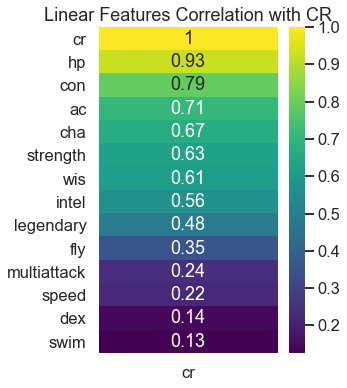

In [6]:
CR_corr = df.corr()[['cr']].sort_values(by='cr', ascending=False)

plt.figure(figsize=(4, 6))
heatmap = sns.heatmap(CR_corr, annot=True, cmap="viridis")
heatmap.set_title('Linear Features Correlation with CR'), plt.savefig('../Images/Lin_FeaturesvsCR.png', bbox_inches='tight');

In [7]:
# Based on the above, the simple base model will use the top three independent variables
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
X_train = train[['hp', 'con', 'ac']]
y_train = train['cr']

linreg.fit(X_train, y_train)

X_test = test[['hp', 'con', 'ac']]
y_test = test['cr']

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

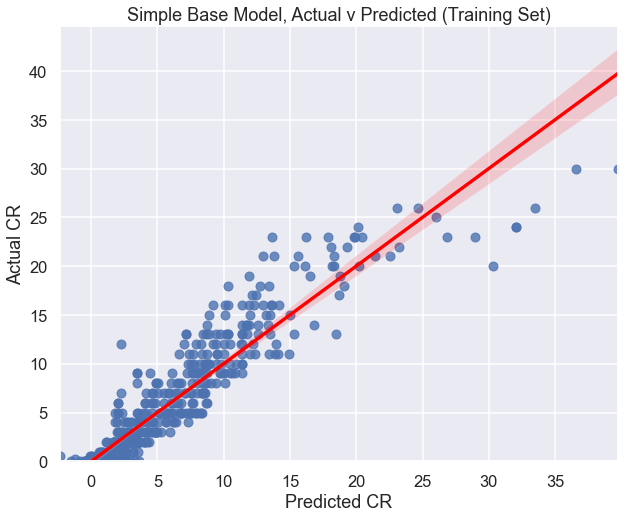

In [8]:
fig, ax = plt.subplots(figsize= (10, 8))
sns.regplot(x = y_train_pred, y = y_train, line_kws={"color": "red"})

plt.title('Simple Base Model, Actual v Predicted (Training Set)')
plt.xlabel('Predicted CR'), plt.ylabel('Actual CR'), plt.ylim(0, None) 
plt.savefig('../Images/Base_model.png', bbox_inches='tight');

With only three variables this is a very decent model.
Next, a function will be defined to quickly calculate the R2 score and RMSE of both the train and test sets, as well as check the R-adjusted score, all within a dataframe that can be updated as the iterations continue.

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

def get_model(Xtr, ytr, ytr_pred, ytst, ytst_pred):
    import math
    r2_train = r2_score(ytr, ytr_pred)
    r2_test = r2_score(ytst, ytst_pred)
    
    N = len(Xtr)
    p = len(Xtr.columns)
    x = (1-r2_train)
    y = (N-1) / (N-p-1)
    adj_r2 = (1 - (x * y))
    
    rmse_train = math.sqrt(mean_squared_error(ytr, ytr_pred))
    rmse_test = math.sqrt(mean_squared_error(ytst, ytst_pred))
    
    calcs = ["{:.2f}".format(r2_train), "{:.2f}".format(r2_test), "{:.2f}".format(adj_r2), rmse_train, rmse_test, p]
    
    return calcs

In [10]:
model_list = ['R2 Train', 'R2 Test', 'Adjusted R2', 'RMSE Train', 'RMSE Test', 'Num of Variables']
scores = get_model(X_train, y_train, y_train_pred, y_test, y_test_pred)
model_df = pd.DataFrame(scores, model_list).transpose()
model_df

,R2 Train,R2 Test,Adjusted R2,RMSE Train,RMSE Test,Num of Variables
0,0.87,0.87,0.87,2.23501,2.25124,3


Again, for only 3 variables this is a great score set.

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

In [12]:
# Defining function to make qq-plots
def model_qq(X_train, y_train, formula):
    train_simp = X_train.join(y_train)
    model = ols(formula, train_simp).fit()
    residuals = model.resid
    qq_plot = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);
    return qq_plot;

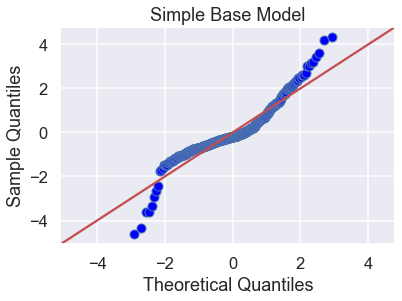

In [13]:
formula = 'cr ~ hp + con + ac'
model_qq(X_train, y_train, formula)
plt.title('Simple Base Model'), plt.savefig('../Images/Base_qqplot.png', bbox_inches='tight');

The qq-plot is showing quite a bit of skewness, and from the cleaning & exploration notebook this could be from the dependent variable `cr`.

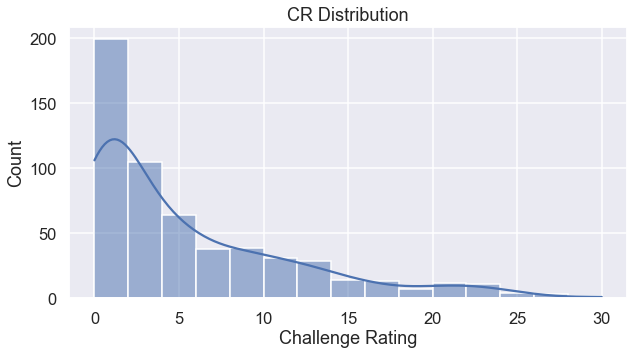

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(train['cr'], kde=True)
plt.title('CR Distribution'), plt.xlabel('Challenge Rating')
plt.savefig('../Images/C_hist.png', bbox_inches='tight');

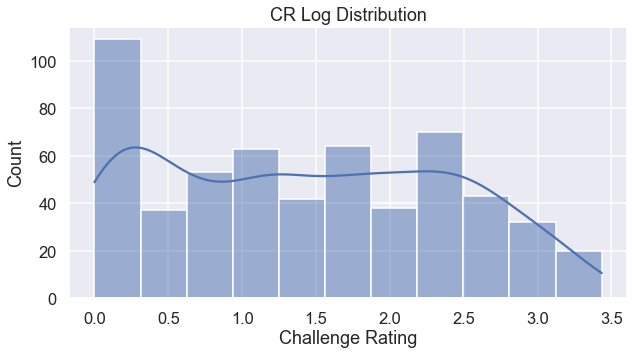

In [15]:
#checking if log1p transforming this column will normalise this variable
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(np.log1p(train['cr']), kde=True)
plt.title('CR Log Distribution'), plt.xlabel('Challenge Rating'), 
plt.savefig('../Images/Clog_hist.png', bbox_inches='tight');

Still not a great distribution, but experimentation will continue to at least check the effect on the qq-plots or R2 scores.

In [16]:
train['cr'] = np.log1p(train['cr'])
test['cr'] = np.log1p(test['cr'])

<ipython-input-16-df7c3e8bebf7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cr'] = np.log1p(train['cr'])
<ipython-input-16-df7c3e8bebf7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cr'] = np.log1p(test['cr'])


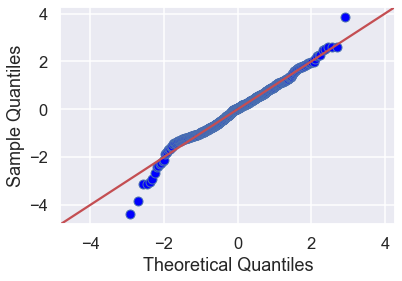

In [17]:
formula = 'cr ~ hp + con + ac'
model_qq(X_train, y_train, formula);

Much better skewnes, now to check accuracy.

In [18]:
y_train = train['cr']
y_test = test['cr']

linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

In [19]:
scores = get_model(X_train, y_train, y_train_pred, y_test, y_test_pred)
model_df.loc[len(model_df)] = scores
model_df

,R2 Train,R2 Test,Adjusted R2,RMSE Train,RMSE Test,Num of Variables
0,0.87,0.87,0.87,2.23501,2.25124,3
1,0.72,0.76,0.72,0.514225,0.483629,3


From the R2 scores dipping so much, it seems the independent variables are already linearly correlated with `cr`, so this iteration change will be reversed.

In [20]:
train['cr'] = np.exp(train['cr'])
test['cr'] = np.exp(test['cr'])

<ipython-input-20-5b01d1723df2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cr'] = np.exp(train['cr'])
<ipython-input-20-5b01d1723df2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cr'] = np.exp(test['cr'])


Next it's time to add the other base stats into the configuration.

In [21]:
X_train = train[['ac', 'hp', 'strength', 'dex', 'con', 'intel', 'wis', 'cha']]
X_test = test[['ac', 'hp', 'strength', 'dex', 'con', 'intel', 'wis', 'cha']]
y_train = train['cr']
y_test = test['cr']

linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

In [22]:
scores = get_model(X_train, y_train, y_train_pred, y_test, y_test_pred)
model_df.loc[len(model_df)] = scores
model_df

,R2 Train,R2 Test,Adjusted R2,RMSE Train,RMSE Test,Num of Variables
0,0.87,0.87,0.87,2.23501,2.25124,3
1,0.72,0.76,0.72,0.514225,0.483629,3
2,0.90,0.89,0.90,1.97613,2.0472,8


This has improved a fair amount from the base model, next to check distributions of these features.

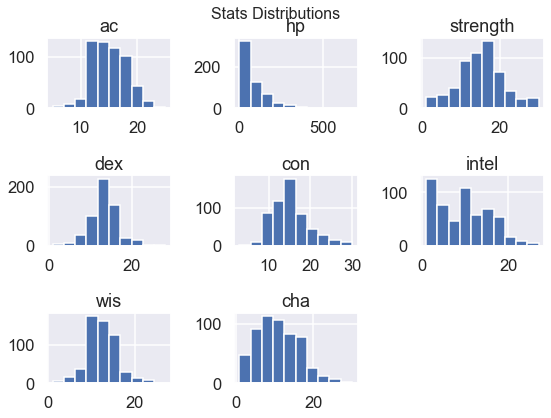

In [23]:
X_train.hist(figsize=(8, 6))
plt.tight_layout()
plt.suptitle('Stats Distributions', size=16), 
plt.savefig('../Images/Stat_Dists.png', bbox_inches='tight');

In [24]:
#normalising the skewed stats
skew_vars = ['ac', 'hp', 'cha', 'intel']
train[skew_vars] = np.log(train[skew_vars])
test[skew_vars] = np.log(test[skew_vars])

C:\Users\jocel\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [25]:
train.head()

,size,type,ac,hp,cr,speed,swim,fly,strength,dex,con,intel,wis,cha,legendary,multiattack
75,large,fiend,2.833213,4.499810,5.0,60,0,0,19,15,14,2.564949,12,2.639057,0,0
106,medium,dragon,2.833213,3.465736,3.0,30,30,60,17,10,15,2.484907,11,2.708050,0,0
574,large,fiend,2.639057,4.700480,9.0,40,0,0,18,13,17,1.945910,14,2.197225,0,0
167,medium,beast,2.564949,3.258097,2.0,40,0,0,15,15,14,1.386294,12,1.791759,0,0
716,large,beast,2.484907,3.258097,2.0,50,0,0,17,15,13,1.098612,12,2.079442,0,0


In [26]:
X_train = train[['ac', 'hp', 'strength', 'dex', 'con', 'intel', 'wis', 'cha', 'speed']]
X_test = test[['ac', 'hp', 'strength', 'dex', 'con', 'intel', 'wis', 'cha', 'speed']]

linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

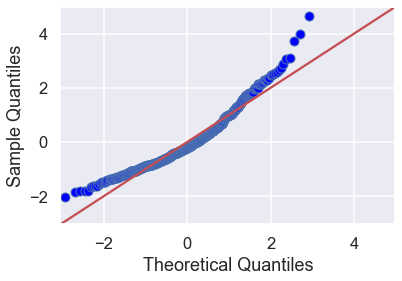

In [27]:
model_qq(X_train, y_train, formula);

In [28]:
scores = get_model(X_train, y_train, y_train_pred, y_test, y_test_pred)
model_df.loc[len(model_df)] = scores
model_df

,R2 Train,R2 Test,Adjusted R2,RMSE Train,RMSE Test,Num of Variables
0,0.87,0.87,0.87,2.23501,2.25124,3
1,0.72,0.76,0.72,0.514225,0.483629,3
2,0.90,0.89,0.90,1.97613,2.0472,8
3,0.78,0.79,0.78,2.93207,2.82026,9


Once again, normalisation of vairables has improved perceived skewness in the qq-plot, but decreased accuracy scores significantly, so this iteration will be reversed.

In [29]:
train[skew_vars] = np.exp(train[skew_vars])
test[skew_vars] = np.exp(test[skew_vars])

C:\Users\jocel\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Before inputting the str data types, the 0 skewed and boolean values will be added to see if the model can account for these columns.

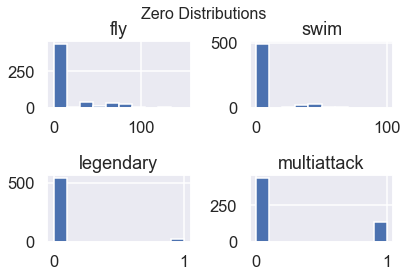

In [30]:
train[['fly', 'swim', 'legendary', 'multiattack']].hist()
plt.tight_layout()
plt.suptitle('Zero Distributions', size=16), 
plt.savefig('../Images/Zero_Dists.png', bbox_inches='tight');

In [31]:
X_train = train.drop(['cr', 'size', 'type'], axis=1)
X_test = test.drop(['cr', 'size', 'type'], axis=1)

linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

In [32]:
scores = get_model(X_train, y_train, y_train_pred, y_test, y_test_pred)
model_df.loc[len(model_df)] = scores
model_df

,R2 Train,R2 Test,Adjusted R2,RMSE Train,RMSE Test,Num of Variables
0,0.87,0.87,0.87,2.23501,2.25124,3
1,0.72,0.76,0.72,0.514225,0.483629,3
2,0.90,0.89,0.90,1.97613,2.0472,8
3,0.78,0.79,0.78,2.93207,2.82026,9
4,0.90,0.90,0.90,1.94013,1.99122,13


0.9 R2 score accross the board with minimal RMSE scores, now for the transformation of categorical variables `size` and `type`.

In [33]:
train['size'].unique()

array(['large', 'medium', 'tiny', 'gargantuan', 'small', 'huge'],
      dtype=object)

In [34]:
#This column is a linear scale, so the stings can just be replaced with numbers that correlate
sizes = ['tiny', 'small', 'medium', 'large', 'huge', 'gargantuan']
int_sizes = [1, 2, 3, 4, 5, 6]

In [35]:
train['size'].replace(to_replace=sizes, value=int_sizes)

75     4
106    3
574    4
167    3
716    4
      ..
213    2
611    3
507    4
370    4
223    4
Name: size, Length: 571, dtype: int64

In [36]:
train['size'] = train['size'].replace(to_replace=sizes, value=int_sizes)
test['size'] = test['size'].replace(to_replace=sizes, value=int_sizes)

<ipython-input-36-fea7c6d67f91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['size'] = train['size'].replace(to_replace=sizes, value=int_sizes)
<ipython-input-36-fea7c6d67f91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['size'] = test['size'].replace(to_replace=sizes, value=int_sizes)


In [37]:
X_train = train.drop(['cr', 'type'], axis=1)
X_test = test.drop(['cr', 'type'], axis=1)

linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

In [38]:
scores = get_model(X_train, y_train, y_train_pred, y_test, y_test_pred)
model_df.loc[len(model_df)] = scores
model_df

,R2 Train,R2 Test,Adjusted R2,RMSE Train,RMSE Test,Num of Variables
0,0.87,0.87,0.87,2.23501,2.25124,3
1,0.72,0.76,0.72,0.514225,0.483629,3
2,0.90,0.89,0.90,1.97613,2.0472,8
3,0.78,0.79,0.78,2.93207,2.82026,9
4,0.90,0.90,0.90,1.94013,1.99122,13
5,0.91,0.89,0.90,1.93543,2.00389,14


Now to dummy one-hot encode the `type` column for it's 14 distinct categories.

In [39]:
df['type'].value_counts()

humanoid       189
beast          105
fiend           89
monstrosity     87
undead          50
dragon          47
elemental       38
aberration      37
giant           27
construct       24
plant           24
fey             21
ooze             8
celestial        8
swarm            8
Name: type, dtype: int64

In [40]:
pd.get_dummies(train, columns=['type'])

,size,ac,hp,cr,speed,swim,fly,strength,dex,con,...,type_elemental,type_fey,type_fiend,type_giant,type_humanoid,type_monstrosity,type_ooze,type_plant,type_swarm,type_undead
75,4,17.0,90.0,5.00,60,0,0,19,15,14,...,0,0,1,0,0,0,0,0,0,0
106,3,17.0,32.0,3.00,30,30,60,17,10,15,...,0,0,0,0,0,0,0,0,0,0
574,4,14.0,110.0,9.00,40,0,0,18,13,17,...,0,0,1,0,0,0,0,0,0,0
167,3,13.0,26.0,2.00,40,0,0,15,15,14,...,0,0,0,0,0,0,0,0,0,0
716,4,12.0,26.0,2.00,50,0,0,17,15,13,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,2,12.0,3.0,1.00,10,0,60,6,15,10,...,0,0,0,0,0,0,0,0,0,0
611,3,16.0,168.0,17.00,30,0,0,17,12,23,...,0,0,0,0,0,0,0,0,0,0
507,4,13.0,59.0,4.00,40,0,0,20,12,17,...,0,0,0,0,0,1,0,0,0,0
370,4,12.0,45.0,3.00,0,40,0,18,13,15,...,0,0,0,0,0,0,0,0,0,0


In [41]:
train = pd.get_dummies(train, columns=['type'])
test = pd.get_dummies(test, columns=['type'])

In [42]:
X_train = train.drop('cr', axis=1)
X_test = test.drop('cr', axis=1)

linreg.fit(X_train, y_train)

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

In [43]:
scores = get_model(X_train, y_train, y_train_pred, y_test, y_test_pred)
model_df.loc[len(model_df)] = scores
model_df

,R2 Train,R2 Test,Adjusted R2,RMSE Train,RMSE Test,Num of Variables
0,0.87,0.87,0.87,2.23501,2.25124,3
1,0.72,0.76,0.72,0.514225,0.483629,3
2,0.90,0.89,0.90,1.97613,2.0472,8
3,0.78,0.79,0.78,2.93207,2.82026,9
4,0.90,0.90,0.90,1.94013,1.99122,13
5,0.91,0.89,0.90,1.93543,2.00389,14
6,0.91,0.91,0.91,1.8621,1.85675,29


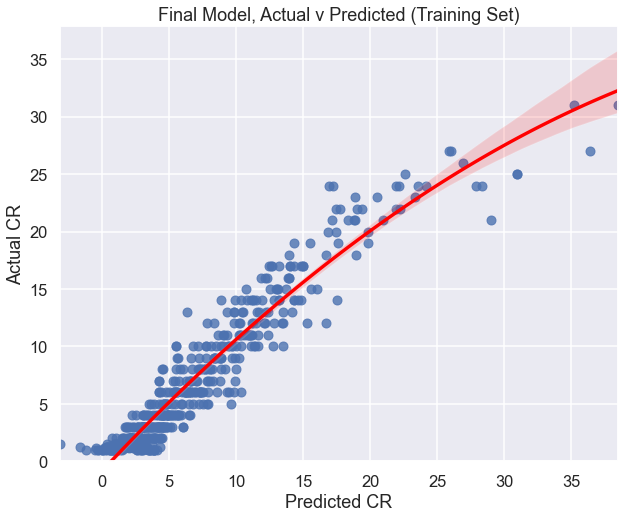

In [44]:
fig, ax = plt.subplots(figsize= (10, 8))
sns.regplot(x = y_train_pred, y = y_train, order=2, line_kws={"color": "red"})
plt.title('Final Model, Actual v Predicted (Training Set)')
plt.xlabel('Predicted CR'), plt.ylabel('Actual CR'), plt.ylim(0, None), 
plt.savefig('../Images/Final_Model.png', bbox_inches='tight');

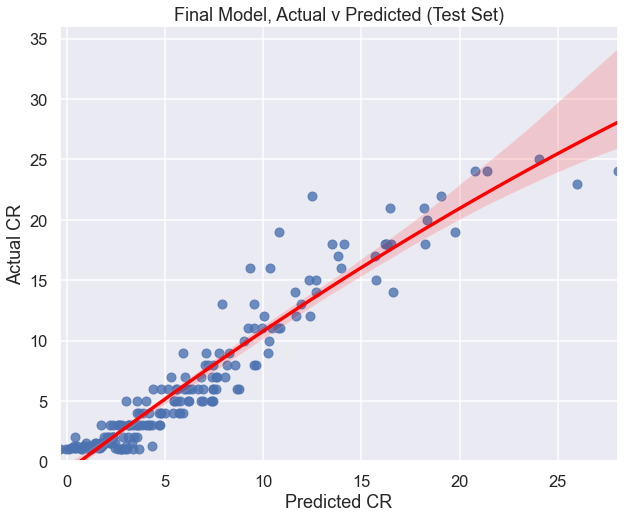

In [45]:
fig, ax = plt.subplots(figsize= (10, 8))
sns.regplot(x = y_test_pred, y = y_test, order=2, line_kws={"color": "red"})

plt.title('Final Model, Actual v Predicted (Test Set)')
plt.xlabel('Predicted CR'), plt.ylabel('Actual CR'), plt.ylim(0, None), 
plt.savefig('../Images/Final_ModelTest.png', bbox_inches='tight');

In [46]:
#Using RFR to provide inference into the top 10 most correlated variabls to cr
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg.fit(X_train, y_train)
feat_imps = sorted(zip(rfreg.feature_importances_,
                       X_train.columns),reverse=True)
[i[1] for i in feat_imps[:10]]

['hp',
 'intel',
 'cha',
 'ac',
 'con',
 'wis',
 'strength',
 'dex',
 'speed',
 'multiattack']

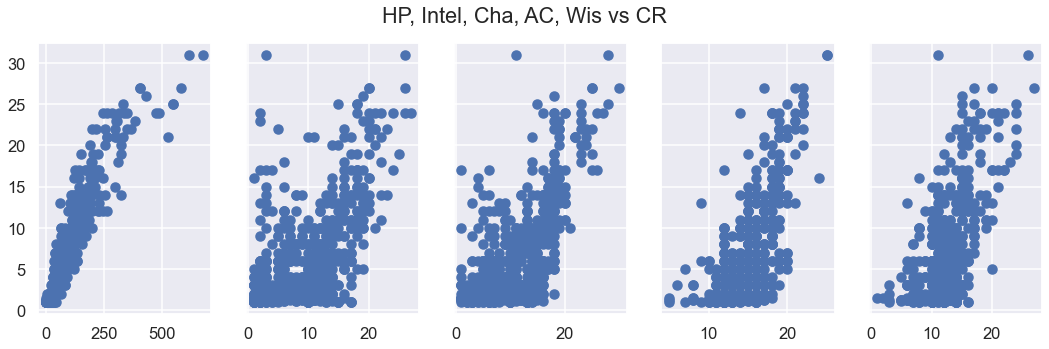

In [47]:
#checking for negative/positive correlation in the top 5 as an exmaple
fig, ax = plt.subplots(figsize=(18, 5), nrows=1, ncols=5, sharey=True)
ax[0].scatter('hp', 'cr', data=train)
ax[1].scatter('intel', 'cr', data=train)
ax[2].scatter('cha', 'cr', data=train)
ax[3].scatter('ac', 'cr', data=train)
ax[4].scatter('wis', 'cr', data=train)
plt.suptitle('HP, Intel, Cha, AC, Wis vs CR')
plt.savefig('../Images/CR_vs_stats.png', bbox_inches='tight');

In [48]:
print(X_train.columns)

Index(['size', 'ac', 'hp', 'speed', 'swim', 'fly', 'strength', 'dex', 'con',
       'intel', 'wis', 'cha', 'legendary', 'multiattack', 'type_aberration',
       'type_beast', 'type_celestial', 'type_construct', 'type_dragon',
       'type_elemental', 'type_fey', 'type_fiend', 'type_giant',
       'type_humanoid', 'type_monstrosity', 'type_ooze', 'type_plant',
       'type_swarm', 'type_undead'],
      dtype='object')


Using the same stats from a Home-brew Monster, the values are inputted in the same order to predict it's `cr` using this final model iteration.

In [49]:
Xnew = np.array([5, 19, 190, 40, 0, 80, 18, 17, 21, 18, 15, 17, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]).reshape(-1, 29)
ynew = linreg.predict(Xnew)
print(ynew.astype(int))

[14]


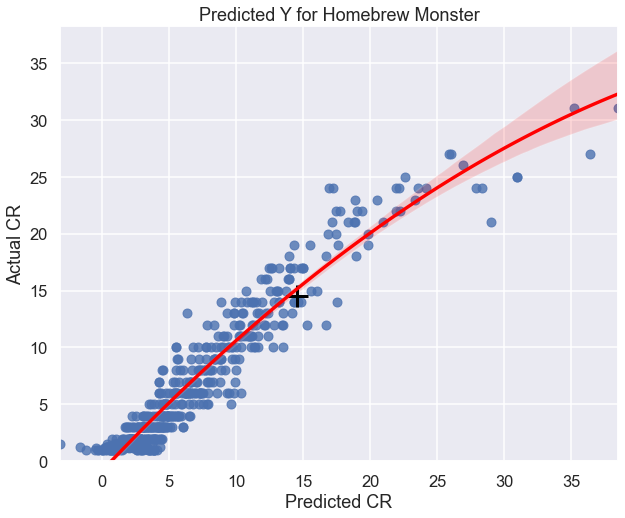

In [50]:
fig, ax = plt.subplots(figsize= (10, 8))
sns.regplot(x = y_train_pred, y = y_train, order=2, line_kws={"color": "red"})
sns.scatterplot(x=ynew, y=ynew, s=500, color="black", marker="+", linewidth=3)
plt.title('Predicted Y for Homebrew Monster')
plt.xlabel('Predicted CR'), plt.ylabel('Actual CR'), plt.ylim(0, None),
plt.savefig('../Images/CR_prediction.png', bbox_inches='tight');